In [1]:
!pip install prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import os


In [2]:
os.makedirs("visualizations", exist_ok=True)


In [4]:
df_hr = pd.read_csv('/content/heartrate_seconds_merged.csv')
df_sleep = pd.read_csv('/content/sleepDay_merged.csv')

df_hr.head(), df_sleep.head()

/tmp/ipython-input-1212600597.py:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hr = pd.read_csv('/content/heartrate_seconds_merged.csv')


(                                heartrate_seconds_merged
 Id         Time                                    Value
 2022484408 4/12/2016 7:21:00 AM                       97
            4/12/2016 7:21:05 AM                      102
            4/12/2016 7:21:10 AM                      105
            4/12/2016 7:21:20 AM                      103,
                                                                       sleepDay_merged
 Id         SleepDay              TotalSleepRecords TotalMinutesAsleep  TotalTimeInBed
 1503960366 4/12/2016 12:00:00 AM 1                 327                            346
            4/13/2016 12:00:00 AM 2                 384                            407
            4/15/2016 12:00:00 AM 1                 412                            442
            4/16/2016 12:00:00 AM 2                 340                            367)

In [21]:
df_hr['Time'] = pd.to_datetime(df_hr['Time'])
df_hr['Value'] = pd.to_numeric(df_hr['Value'], errors='coerce')
df_hr = df_hr.sort_values('Time')
hr_minute = df_hr.set_index('Time')['Value'].resample('1min').mean()
hr_minute = hr_minute.reset_index()
hr_minute = hr_minute.rename(columns={'Value': 'heart_rate'})
hr_minute = hr_minute.dropna()

hr_minute.head()

,Time,heart_rate
0,2016-04-12 00:00:00,63.521739
1,2016-04-12 00:01:00,65.913043
2,2016-04-12 00:02:00,67.000000
3,2016-04-12 00:03:00,67.000000
4,2016-04-12 00:04:00,67.000000


In [32]:
df_sleep.columns = ['Id', 'SleepDay', 'TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed']
df_sleep['SleepDay'] = pd.to_datetime(df_sleep['SleepDay'])
df_sleep['TotalMinutesAsleep'] = pd.to_numeric(df_sleep['TotalMinutesAsleep'], errors='coerce') # Convert to numeric

sleep_day = df_sleep[['SleepDay', 'TotalMinutesAsleep']]
sleep_day = sleep_day.rename(columns={'SleepDay': 'ds', 'TotalMinutesAsleep': 'sleep_minutes'})

sleep_day.head()

,ds,sleep_minutes
0,2016-04-13,384
1,2016-04-15,412
2,2016-04-16,340
3,2016-04-17,700
4,2016-04-19,304


In [26]:
hr = hr_minute.rename(columns={'Time': 'ds', 'heart_rate': 'y'})

model_hr = Prophet()
model_hr.fit(hr)

future_hr = model_hr.make_future_dataframe(periods=0, freq='T')
forecast_hr = model_hr.predict(future_hr)

hr = hr.merge(forecast_hr[['ds','yhat']], on='ds')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


In [27]:
hr['residual'] = abs(hr['y'] - hr['yhat'])
thr_hr = hr['residual'].mean() + 2*hr['residual'].std()

hr['is_anomaly'] = hr['residual'] > thr_hr
hr['label'] = hr['is_anomaly'].apply(lambda x: 'Abnormal' if x else 'Normal')

hr.head()


,ds,y,yhat,residual,is_anomaly,label
0,2016-04-12 00:00:00,63.521739,70.971570,7.449831,False,Normal
1,2016-04-12 00:01:00,65.913043,70.915822,5.002778,False,Normal
2,2016-04-12 00:02:00,67.000000,70.860229,3.860229,False,Normal
3,2016-04-12 00:03:00,67.000000,70.804794,3.804794,False,Normal
4,2016-04-12 00:04:00,67.000000,70.749518,3.749518,False,Normal


In [28]:
sl = sleep_day.rename(columns={'sleep_minutes': 'y'})

model_sl = Prophet()
model_sl.fit(sl)

future_sl = model_sl.make_future_dataframe(periods=0, freq='D')
forecast_sl = model_sl.predict(future_sl)

sl = sl.merge(forecast_sl[['ds','yhat']], on='ds')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
sl['y'] = pd.to_numeric(sl['y'], errors='coerce') # Ensure 'y' is numeric
sl['residual'] = abs(sl['y'] - sl['yhat'])
thr_sl = sl['residual'].mean() + 2*sl['residual'].std()

sl['is_anomaly'] = sl['residual'] > thr_sl
sl['label'] = sl['is_anomaly'].apply(lambda x: 'Abnormal' if x else 'Normal')

sl.head()

,ds,y,yhat,residual,is_anomaly,label
0,2016-04-12,327,411.973268,84.973268,False,Normal
1,2016-04-13,384,441.852615,57.852615,False,Normal
2,2016-04-15,412,410.814451,1.185549,False,Normal
3,2016-04-16,340,426.595224,86.595224,False,Normal
4,2016-04-17,700,458.782809,241.217191,False,Normal


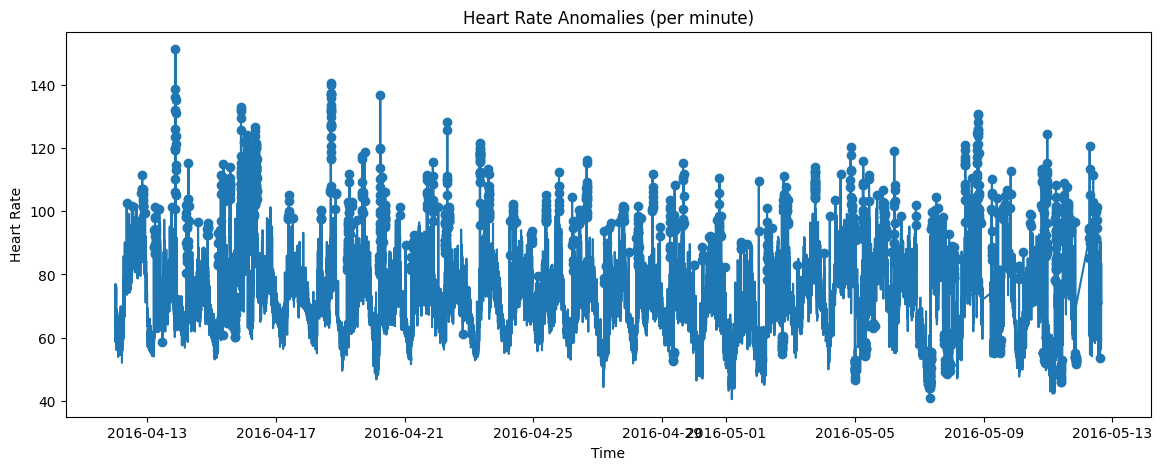

In [36]:
plt.figure(figsize=(14,5))
plt.plot(hr['ds'], hr['y'])
plt.scatter(hr[hr['is_anomaly']]['ds'], hr[hr['is_anomaly']]['y'])
plt.title('Heart Rate Anomalies (per minute)')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.savefig('visualizations/heart_rate_anomalies.png')
plt.show()


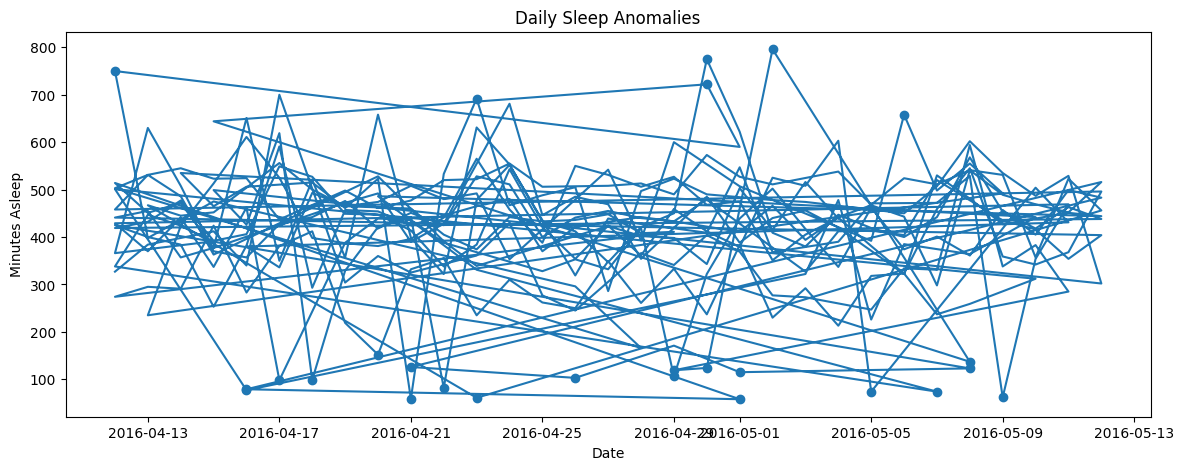

In [37]:
plt.figure(figsize=(14,5))
plt.plot(sl['ds'], sl['y'])
plt.scatter(sl[sl['is_anomaly']]['ds'], sl[sl['is_anomaly']]['y'])
plt.title('Daily Sleep Anomalies')
plt.xlabel('Date')
plt.ylabel('Minutes Asleep')
plt.savefig('visualizations/sleep_anomalies.png')
plt.show()


In [39]:
hr.to_csv('heart_rate_m3_output.csv', index=False)
sl.to_csv('sleep_m3_output.csv', index=False)

print("Milestone 3 Completed Successfully!")
print("Saved plots into visualizations/ folder")


Milestone 3 Completed Successfully!
Saved plots into visualizations/ folder
